### Tune layer size.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.metrics import confusion_matrix, matthews_corrcoef, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier

# Change the following variables according to your needs
species = 'human'
tissue = 'heart'

# -------------------- Load Data --------------------
esslnc_path = f'../../data/benchmark/{species}/ess_lpi.csv'  
nonesslnc_path = f'../../data/benchmark/{species}/noness_lpi.csv'  
lncRNA_path = f'../../HinSAGE/{species}/lncRNA_embeddings_{tissue}.csv'

lnc = pd.read_csv(lncRNA_path, index_col=0)
esslnc = pd.read_csv(esslnc_path)
nonesslnc = pd.read_csv(nonesslnc_path)

esslnc_id = set(esslnc['lncRNA_ID'])
nonesslnc_id = set(nonesslnc['lncRNA_ID'])

lnc_ess = lnc[lnc.index.isin(esslnc_id)]
lnc_noness = lnc[lnc.index.isin(nonesslnc_id)]

X_positive = lnc_ess.to_numpy()
X_negative = lnc_noness.to_numpy()
ids_positive = np.array(lnc_ess.index)
ids_negative = np.array(lnc_noness.index)

X_all = np.vstack((X_positive, X_negative))
y_all = np.hstack((np.ones(len(X_positive)), np.zeros(len(X_negative))))
ids_all = np.hstack((ids_positive, ids_negative))

# -------------------- Config --------------------
hidden_layer_sizes = [32, 64, 128, 256]  
alpha = 1e-3
learning_rate = 0.01
input_dim = X_all.shape[1]

metrics_df = pd.DataFrame()

# -------------------- Grid Search --------------------
for i in hidden_layer_sizes:
    for j in hidden_layer_sizes:

        all_true_labels = []
        all_pred_labels = []
        all_pred_probs = []
        # Prepare DataFrame to save experimental records
        experiment_records = pd.DataFrame()

        if species == 'mouse':
            cv = LeaveOneOut() 
        else:
            cv = KFold(n_splits=10, shuffle=True, random_state=42)

        for fold, (train_index, test_index) in enumerate(cv.split(X_all)):
            X_train, X_test = X_all[train_index], X_all[test_index]
            y_train, y_test = y_all[train_index], y_all[test_index]
            ids_train, ids_test = ids_all[train_index], ids_all[test_index]

            scaler = MinMaxScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            # Instantiate custom MLP classifier
            mlp = MLPClassifier(
                hidden_layer_sizes=(i, j),
                activation='relu',
                alpha=1e-3,
                learning_rate_init=0.01,
                max_iter=500,
                random_state=42
            )
            mlp.fit(X_train_scaled, y_train)

            prob = mlp.predict_proba(X_test_scaled)[:, 1]
            pred = mlp.predict(X_test_scaled)

            all_true_labels.extend(y_test.tolist())
            all_pred_labels.extend(pred.tolist())
            all_pred_probs.extend(prob.tolist())

            fold_data = {
                'Fold': fold + 1,
                'Train_IDs': [list(ids_train)],
                'Train_Labels': [list(y_train)],
                'Test_IDs': [list(ids_test)],
                'Test_Labels': [list(y_test)],
                'Predictions': [list(pred)],
                'Decision_Scores': [list(prob)],
            }
            fold_df = pd.DataFrame(fold_data)
            experiment_records = pd.concat([experiment_records, fold_df], ignore_index=True)

        # -------------------- Metrics --------------------
        tn, fp, fn, tp = confusion_matrix(all_true_labels, all_pred_labels).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        f1 = 2 * (ppv * sensitivity) / (ppv + sensitivity) if (ppv + sensitivity) > 0 else 0
        mcc = matthews_corrcoef(all_true_labels, all_pred_labels)

        # Compute ROC curve and PR curve data
        fpr, tpr, _ = roc_curve(all_true_labels, all_pred_probs)
        roc_auc = auc(fpr, tpr)

        precision, recall, _ = precision_recall_curve(all_true_labels, all_pred_probs)
        pr_auc = auc(recall, precision)

        metrics = {
            'layer_size_1': i,
            'layer_size_2': j,
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'PPV': ppv,
            'F1 Score': f1,
            'Accuracy': accuracy,
            'MCC': mcc,
            'roc_auc': roc_auc,
            'pr_auc': pr_auc
        }

        metrics_df = pd.concat([metrics_df, pd.DataFrame([metrics])], ignore_index=True)
        print(f"Finished structure: ({i}, {j})")
        experiment_records.to_csv(f'./experiment_details/{species}/mlp_layersize_experiment_details_{i}_{j}.csv', index=False)

# -------------------- Save Results --------------------
metrics_df.to_csv(f'./performance/{species}/mlp_layersize_metrics.csv', index=False)
print("All configurations completed and saved.")


Finished structure: (32, 32)


/home/xiao/miniconda3/envs/esslnc/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


### Cross validation

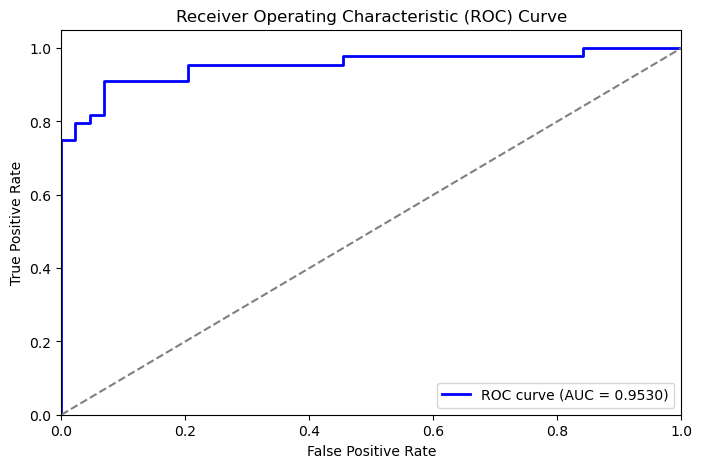

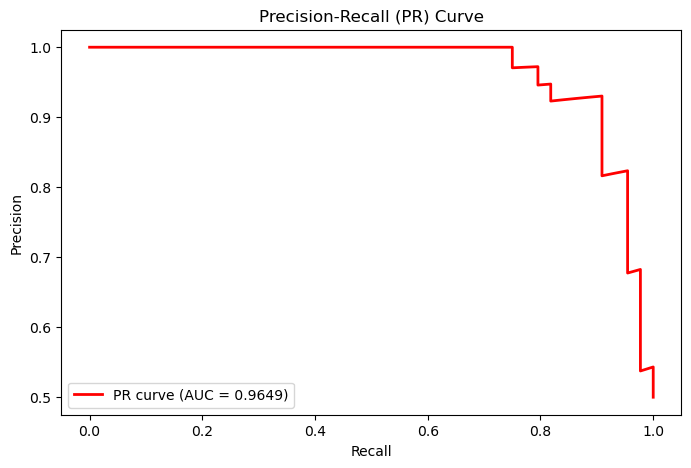

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.metrics import (
    confusion_matrix, matthews_corrcoef, roc_curve,
    auc, precision_recall_curve
)
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
import os

species = 'mouse'
tissue = 'heart'

# ---------------------- 1. Load Data ----------------------
esslnc_path = f'../../data/benchmark/{species}/ess_lpi.csv'
nonesslnc_path = f'../../data/benchmark/{species}/noness_lpi.csv'

lncRNA_path = f'../../HinSAGE/{species}/lncRNA_embeddings_{tissue}.csv'

lnc = pd.read_csv(lncRNA_path, index_col=0, header=None)
esslnc = pd.read_csv(esslnc_path)
nonesslnc = pd.read_csv(nonesslnc_path)

esslnc_id = set(esslnc['lncRNA_ID'])
nonesslnc_id = set(nonesslnc['lncRNA_ID'])

lnc_ess = lnc[lnc.index.isin(esslnc_id)]
lnc_noness = lnc[lnc.index.isin(nonesslnc_id)]

X_pos = lnc_ess.to_numpy()
X_neg = lnc_noness.to_numpy()
y_pos = np.ones(len(X_pos))
y_neg = np.zeros(len(X_neg))

X_all = np.vstack([X_pos, X_neg])
y_all = np.hstack([y_pos, y_neg])
ids_all = np.hstack([lnc_ess.index, lnc_noness.index])

# ---------------------- 2. Init Containers ----------------------
all_true_labels = []
all_pred_labels = []
all_pred_probs = []
experiment_records = pd.DataFrame()
roc_data, pr_data = [], []

# ---------------------- 3. Cross-validation ----------------------
# Initialize cross-validation
if species == 'mouse':
    cv = LeaveOneOut() 
    layer_size = (32,32)
else:
    cv = KFold(n_splits=10, shuffle=True, random_state=42)
    layer_size = (32, 64)

for fold, (train_idx, test_idx) in enumerate(cv.split(X_all)):
    X_train, X_test = X_all[train_idx], X_all[test_idx]
    y_train, y_test = y_all[train_idx], y_all[test_idx]
    ids_train, ids_test = ids_all[train_idx], ids_all[test_idx]

    # Normalize using MinMaxScaler
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    mlp = MLPClassifier(
        hidden_layer_sizes=layer_size,
        activation='relu',
        alpha=1e-3,
        learning_rate_init=0.01,
        max_iter=500,
        random_state=42
    )
    mlp.fit(X_train_scaled, y_train)

    prob = mlp.predict_proba(X_test_scaled)[:, 1]
    pred = mlp.predict(X_test_scaled)

    all_true_labels.extend(y_test.tolist())
    all_pred_labels.extend(pred.tolist())
    all_pred_probs.extend(prob.tolist())


    # Save fold-wise predictions
    fold_data = {
        'Fold': fold + 1,
        'Train_IDs': [list(ids_train)],
        'Train_Labels': [list(y_train)],
        'Test_IDs': [list(ids_test)],
        'Test_Labels': [list(y_test)],
        'Predictions': [list(pred)],
        'Decision_Scores': [list(prob)]
    }
    experiment_records = pd.concat([experiment_records, pd.DataFrame(fold_data)], ignore_index=True)

# ---------------------- 4. Evaluate ----------------------
tn, fp, fn, tp = confusion_matrix(all_true_labels, all_pred_labels).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
accuracy = (tp + tn) / (tp + tn + fp + fn)
f1 = 2 * (ppv * sensitivity) / (ppv + sensitivity) if (ppv + sensitivity) > 0 else 0
mcc = matthews_corrcoef(all_true_labels, all_pred_labels)

# ---------------------- 5. Save Results ----------------------
experiment_records.to_csv(f'./experiment_details/{species}/mlp_{tissue}_ELGP(HinSAGE)_experiment_details.csv', index=False)

# ROC & PR curve
fpr, tpr, _ = roc_curve(all_true_labels, all_pred_probs)
roc_auc = auc(fpr, tpr)
roc_data.append(pd.DataFrame({'FPR': fpr, 'TPR': tpr}))

precision, recall, _ = precision_recall_curve(all_true_labels, all_pred_probs)
pr_auc = auc(recall, precision)
pr_data.append(pd.DataFrame({'Recall': recall, 'Precision': precision}))
roc_data[0].to_csv(f'./performance/{species}/curve/roc_curve_{tissue}_ELGP(HinSAGE).csv', index=False)
pr_data[0].to_csv(f'./performance/{species}/curve/pr_curve_{tissue}_ELGP(HinSAGE).csv', index=False)

metrics_row = {
    'Model': 'MLP',
    'Cell_Line': f'{tissue}',
    'Features': 'ELGP(HinSAGE)',
    'Sensitivity(Recall)': sensitivity,
    'Specificity': specificity,
    'PPV(Precision)': ppv,
    'F1_Score': f1,
    'Accuracy': accuracy,
    'MCC': mcc,
    'ROC_AUC': roc_auc,
    'PR_AUC': pr_auc
}

metrics_df = pd.DataFrame([metrics_row])

metrics_output_path = f'./performance/{species}/mlp_{tissue}_summary.csv'
os.makedirs(os.path.dirname(metrics_output_path), exist_ok=True)
if os.path.exists(metrics_output_path):
    metrics_df.to_csv(metrics_output_path, mode='a', header=False, index=False)
else:
    metrics_df.to_csv(metrics_output_path, mode='w', header=True, index=False)


# ---------------------- 6. Plotting ----------------------
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(recall, precision, color='red', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall (PR) Curve')
plt.legend(loc='lower left')
plt.show()


### Predict Step

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier

species = 'mouse'
tissue = 'heart'

if species == 'mouse':
	layer_size = (32,32)
else:
	layer_size = (32, 64)
# ---------------------- 1. Load Data ----------------------

# File paths
esslnc_path = f'../../data/benchmark/{species}/ess_lpi.csv'
nonesslnc_path = f'../../data/benchmark/{species}/noness_lpi.csv'

esslnc = pd.read_csv(esslnc_path)  
nonesslnc = pd.read_csv(nonesslnc_path)

esslnc_id = set(esslnc['lncRNA_ID'])
nonesslnc_id = set(nonesslnc['lncRNA_ID'])

all_samples_path = f'../../HinSAGE/{species}/lncRNA_embeddings_{tissue}.csv'
all_lnc = pd.read_csv(all_samples_path, index_col=0)

lnc_ess = all_lnc[all_lnc.index.isin(esslnc_id)]
lnc_noness = all_lnc[all_lnc.index.isin(nonesslnc_id)]

# Prepare training data
X_positive = lnc_ess.values
X_negative = lnc_noness.values

X_train = np.vstack((X_positive, X_negative))
y_train = np.hstack((np.ones(len(X_positive)), np.zeros(len(X_negative))))

# Split train/test set for validation
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Apply MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

mlp = MLPClassifier(
    hidden_layer_sizes=layer_size,
    activation='relu',
    alpha=1e-3,
    learning_rate_init=0.01,
    max_iter=500,
    random_state=42
)
mlp.fit(X_train_scaled, y_train)

# Predict on all data
X_all = all_lnc.values
ids_all = all_lnc.index

X_all_scaled = scaler.transform(X_all)

scores = mlp.predict_proba(X_all_scaled)[:,1] 
predictions = mlp.predict(X_all_scaled).astype(int)  # Convert predictions to int

# Generate results DataFrame
results_df = pd.DataFrame({'lncRNA_ID': ids_all, 'Score': scores, 'Pre_Label': predictions})

# Save results to CSV file
results_df.to_csv(f'../../results/{species}/MLP_predictions_{tissue}.csv', index=False)
